In [1]:
import numpy as np 
import pandas as pd 
import time
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import utils_clf_models as classifier
import utils_best_search 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 8)})
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/santander-customer-satisfaction/sample_submission.csv
/kaggle/input/santander-customer-satisfaction/train.csv
/kaggle/input/santander-customer-satisfaction/test.csv
/kaggle/input/santander-customer-satisfaction/sample_submission.csv
/kaggle/input/santander-customer-satisfaction/train.csv
/kaggle/input/santander-customer-satisfaction/test.csv


# Importing the data

In [2]:
df = pd.read_csv('/kaggle/input/santander-customer-satisfaction/train.csv')
df['TARGET'].value_counts(normalize=True)

0    0.960431
1    0.039569
Name: TARGET, dtype: float64

In [3]:
3008/(3008+73012)

0.0395685345961589

# Exploring the data

In [4]:
print(df.shape)
print(df.info())
df.head(5)

(76020, 371)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB
None


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [5]:
df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


# Feature Importance

In [6]:
X = df.drop(['TARGET'], axis=1).values
y = df['TARGET'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [7]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

## Based on mean decrease in impurity

Elapsed time to compute the importances: 0.027 seconds


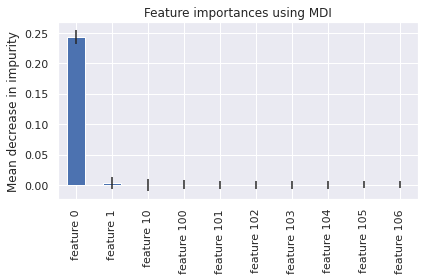

In [8]:
start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
top_std = sorted(std, reverse=True)[:10]

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")


imp_dict = {feature_names[i]: importances[i] for i in range(len(feature_names))}
imp_dict = dict(sorted(imp_dict.items(), key=itemgetter(0)))
forest_importances = pd.Series(list(imp_dict.values())[:10], index=list(imp_dict.keys())[:10])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=top_std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# Single Model Building & Evaluation

## 1-  Naive Bayes

Your model's performance is captured by the following performance evaluation:

{'Accuracy': 0.0662, 'Bal. Accuracy': 0.5124, 'Precision': 0.0411, 'Recall': 0.9974, 'F1_Score': 0.0789, 'log_loss': 32.1821}


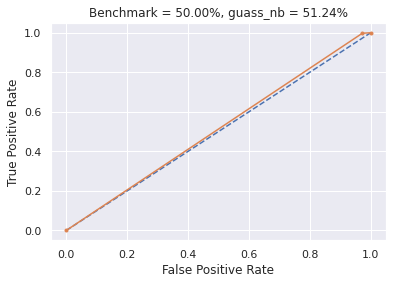

In [9]:
nb = classifier.Classifier(X, y, 'guass_nb')
nb.preprocess_split(size=0.25, state=72)
nb.fit_predict()
nb.metrics(printing=True)
nb.roc_curve()

## 2- K-Nearest Neighbors

Your model's performance is captured by the following performance evaluation:

{'Accuracy': 0.9593, 'Bal. Accuracy': 0.5009, 'Precision': 0.125, 'Recall': 0.0026, 'F1_Score': 0.0051, 'log_loss': 1.1313}


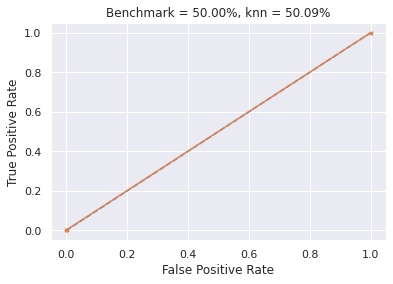

In [10]:
knn = classifier.Classifier(X, y, 'knn')
knn.preprocess_split(size=0.25, state=72)
knn.fit_predict()
knn.metrics(printing=True)
knn.roc_curve()

## 3- Logistic Regression

Your model's performance is captured by the following performance evaluation:

{'Accuracy': 0.9599, 'Bal. Accuracy': 0.5, 'Precision': 0.0, 'Recall': 0.0, 'F1_Score': 0.0, 'log_loss': 0.1897}


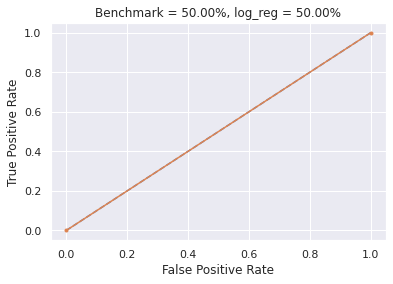

In [11]:
log = classifier.Classifier(X, y, 'log_reg')
log.preprocess_split(size=0.25, state=72)
log.fit_predict()
log.metrics(printing=True)
log.roc_curve()

## 4- Decision Tree

Your model's performance is captured by the following performance evaluation:

{'Accuracy': 0.9242, 'Bal. Accuracy': 0.5474, 'Precision': 0.1181, 'Recall': 0.1378, 'F1_Score': 0.1272, 'log_loss': 2.6188}


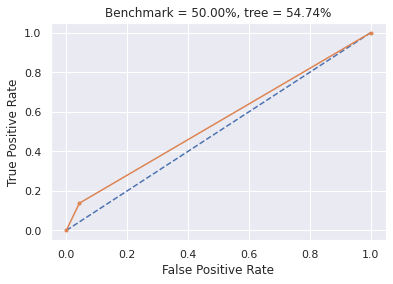

In [12]:
tree = classifier.Classifier(X, y, 'tree')
tree.preprocess_split(size=0.25, state=72)
tree.fit_predict()
tree.metrics(printing=True)
tree.roc_curve()

### What's next? Model Tuning (Best Parameter Search), Ensemble Learning, Model Finalization

# Ensemble Learning

## 1- Random Forest (Given the individual tree performed better than any other model, we will proceed on starting with the random forest)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
rf = RandomForestClassifier(n_estimators = 10000, random_state = 42, class_weight='balanced_subsample')
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21891
           1       0.22      0.02      0.04       915

    accuracy                           0.96     22806
   macro avg       0.59      0.51      0.51     22806
weighted avg       0.93      0.96      0.94     22806



## 2- Bagging (with a tree as base estmiator)

In [15]:
bag = BaggingClassifier(random_state=42)
bag.fit(X_train, y_train)
pred = bag.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     21891
           1       0.21      0.04      0.06       915

    accuracy                           0.96     22806
   macro avg       0.59      0.52      0.52     22806
weighted avg       0.93      0.96      0.94     22806



# Obtain the submission format on the test data

In [16]:
sample = pd.read_csv('/kaggle/input/santander-customer-satisfaction/sample_submission.csv')
sample

,ID,TARGET
0,2,0
1,5,0
2,6,0
3,7,0
4,9,0
...,...,...
75813,151831,0
75814,151832,0
75815,151833,0
75816,151834,0


In [17]:
test_df = pd.read_csv('/kaggle/input/santander-customer-satisfaction/test.csv')
test_df

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.100000
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.720000
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.950000
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.610000
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.730000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75813,151831,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40243.200000
75814,151832,2,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,146961.300000
75815,151833,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,167299.770000
75816,151834,2,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016


In [18]:
X_final_test = test_df.values
final_pred = rf.predict(X_final_test)

In [19]:
frame = {'ID': pd.Series(test_df['ID']), 'TARGET': pd.Series(final_pred)}
result = pd.DataFrame(frame)
result['TARGET'].value_counts(normalize=True)

0    0.996109
1    0.003891
Name: TARGET, dtype: float64

In [20]:
result.head()

,ID,TARGET
0,2,0
1,5,0
2,6,0
3,7,0
4,9,0


In [21]:
result.to_csv('santander_customer_satisfaction_submission.csv', header=True, index=False)